# 20. Data unstructured (motions)
## Contents
- Prerequisites
- Data retrieval
- Data processing
- Text statistics
- Text sentiment
- Text lemmanization
- Text refinement
------------------------------------------------
## Prerequisites

In [31]:
import requests
import time
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import fitz
import re
from concurrent.futures import ThreadPoolExecutor
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="seaborn")
warnings.filterwarnings("ignore", category=FutureWarning)

# text statistics
import textstat
textstat.set_lang("nl")

# text sentiment
from textblob import TextBlob
from textblob_nl import PatternAnalyzer 
from sklearn.preprocessing import StandardScaler

# text lemmanization
import nltk
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
import spacy
nlp = spacy.load("nl_core_news_lg")

# text refinement
from nltk import FreqDist

file_path     = 'C:/Users/Koen.Janssen/OneDrive/Documents/TILBURG UNIVERSITY/Thesis/Data/'
document_path = 'C:/Users/Koen.Janssen/Downloads/Motions/'
api_path      = 'https://gegevensmagazijn.tweedekamer.nl/OData/v4/2.0/'  

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Koen.Janssen\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Koen.Janssen\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


------------------------------------------------
<br>
<br>
<br>

## Data retrieval

In [14]:
dur = time.time()   
file_url  = file_path + '21_data_unstructured_base.csv'            
base_data = pd.read_csv(file_url)
# -------------------------------------------------------------------------------------~----------------------------------------

# functions
# -------------------------------------------------------------------------------------~----------------------------------------
def download_pdf(document_id):                                                         # define function
    document_url = f'{document_path}{document_id}.pdf'                                 # define document url
    api_url = f'{api_path}document/{document_id}/resource'                             # defien api url
    if os.path.exists(document_url): return                                            # if exists
    for attempt in range(5):                                                           # for 5 attempts
        try:                                                                                # try
            response = requests.get(api_url)                                                     # get a response
            if response.status_code == 200: break                                                # if succesfull --> break
        except requests.exceptions.ConnectionError as e:                                    # if error
            time.sleep(5)                                                                        # wait
    with open(document_url, 'wb') as pdf_file:                                         # open document
        pdf_file.write(response.content)                                                    # write to document
    return 

def read_pdf(pdf_url):                                                                 # define function
    text = ""                                                                          # define empty text  
    pdf_document = fitz.open(pdf_url)                                                  # define pdf document 
    for page_number in range(len(pdf_document)):                                       # for every page 
        page = pdf_document[page_number]                                                    # define page
        text += page.get_text()                                                             # add to text 
    return text                                                                        # return text    


# step 1: download motions
# -------------------------------------------------------------------------------------~----------------------------------------
print("\n step 1: download motions")                                                 
print("-----------------------------------------------------------------------")
adoc = base_data['document_id'].tolist()                                               # define all documents         --> adoc
edoc = set([f.split(".pdf")[0] for f in os.listdir(document_path)])                    # define existing documents    --> edoc
ddoc = [doc_id for doc_id in adoc if doc_id not in edoc]                               # define to download documents --> ddoc
print("- check missing documents")
print(f"- to download documents: {len(ddoc)}")

batch_size = 64                                                                        # define batch size
batches = [ddoc[i:i + batch_size] for i in range(0, len(ddoc), batch_size)]            # define batches

with ThreadPoolExecutor(max_workers=16) as executor:                                   # with batch execution
    for i, batch in enumerate(batches, start=1):                                            # For every batch
        results = list(executor.map(download_pdf, batch))                                        # Define result
        print(f"Processed batch {i}/{len(batches)}")                                             # Print progress

edoc = set([f.split(".pdf")[0] for f in os.listdir(document_path)])                    # redefine edoc
ddoc = [doc_id for doc_id in adoc if doc_id not in edoc]                               # redefine ddoc
print("- check missing documents")
print(f"- to download documents: {len(ddoc)}")


# step 2: read motions
# -------------------------------------------------------------------------------------~----------------------------------------
print("\n\n\n step 2: read motions")                                                   # print step                          
print("-----------------------------------------------------------------------")
text_data = pd.DataFrame(columns=["document_id", "text"])                              # define data
rdoc = [file for file in os.listdir(document_path) if file.endswith(".pdf")]           # define to read               --> adoc
batch_size = 2048                                                                      # define batch size
batches = [rdoc[i:i + batch_size] for i in range(0, len(rdoc), batch_size)]            # define batches

for i, batch in enumerate(batches, start=1):                                           # for every batch
    batch_df = pd.DataFrame(columns=['document_id', 'text'])                                # define batch 
    for file in batch:                                                                           # for every file
        document_id = os.path.splitext(file)[0]                                                       # define file id
        rtext = read_pdf((os.path.join(document_path, file)))                                         # read pdf
        rtext = rtext.replace("\n", " ")                                                              # redefine text w/o breaks
        batch_df = pd.DataFrame({
        "document_id": [document_id],
        "text": [rtext]})            
        text_data = pd.concat([text_data, batch_df], ignore_index=True)
    print(f"- processed batch {i}/{len(batches)}, read: {len(text_data)}")
    
edoc = set([f.split(".pdf")[0] for f in os.listdir(document_path)])                    # redefine edoc
ddoc = [doc_id for doc_id in adoc if doc_id not in edoc]                               # redefine ddoc
print(f"\nread romplete: {len(ddoc)==0}")
    

# step 3: display datasets
# -------------------------------------------------------------------------------------~----------------------------------------
print("\n\n\n step 3: display datasets")                                               # print step                                   
print("-----------------------------------------------------------------------")

print("base dataset")                                                                  # print base dataset
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
print(f"unique: {(not base_data['document_id'].duplicated().any())}")                  # print duplicates
print(f"length: {len(base_data)}")                                                     # print length
display(base_data.head(1))                                                             # display row
display((base_data.isna().sum()).to_frame().T)                                         # display nulls
print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

print("text dataset")                                                                  # print text dataset
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
print(f"unique: {(not text_data['document_id'].duplicated().any())}")                  # print duplicates
print(f"length: {len(text_data)}")                                                     # print length
display(text_data.head(1))                                                             # display row
display((text_data.isna().sum()).to_frame().T)                                         # display nulls
print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

print("dataset")                                                                       # print data dataset
data = pd.merge(base_data, text_data, on='document_id', how='inner')                   # merge data
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
print(f"unique: {(not data['document_id'].duplicated().any())}")                       # print duplicates
print(f"length: {len(data)}")                                                          # print length
display(data.head(1))                                                                  # display row
display((data.isna().sum()).to_frame().T)                                              # display nulls
print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


# -------------------------------------------------------------------------------------~----------------------------------------
file_url  = file_path + '22_data_unstructured_retrieved.csv' 
if os.path.exists(file_url):os.remove(file_url) 
data.to_csv(file_url, index=False)
print('\n---------------------------------------------------------------------------------------------------------------------')
print(f"Code duration: {round((time.time()  - dur),3)} seconds")       




 step 1: download motions
-----------------------------------------------------------------------
- check missing documents
- to download documents: 0
- check missing documents
- to download documents: 0


 step 2: read motions
-----------------------------------------------------------------------
- processed batch 1/11, read: 2048
- processed batch 2/11, read: 4096
- processed batch 3/11, read: 6144
- processed batch 4/11, read: 8192
- processed batch 5/11, read: 10240
- processed batch 6/11, read: 12288
- processed batch 7/11, read: 14336
- processed batch 8/11, read: 16384
- processed batch 9/11, read: 18432
- processed batch 10/11, read: 20480
- processed batch 11/11, read: 20666

read romplete: True



 step 3: display datasets
-----------------------------------------------------------------------
base dataset
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
unique: True
length: 20666


,document_id,subject,title
0,08f70318-bcee-4284-95d8-25539822718c,Motie van de leden Van der Staaij en Roemer ov...,Nota over de toestand van ’s Rijks Financiën


,document_id,subject,title
0,0,0,0


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
text dataset
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
unique: True
length: 20666


,document_id,text
0,000368fa-656e-48b5-9ff0-ad7bc86ea80d,Tweede Kamer der Staten-Generaal 2 Vergaderjaa...


,document_id,text
0,0,0


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
dataset
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
unique: True
length: 20666


,document_id,subject,title,text
0,08f70318-bcee-4284-95d8-25539822718c,Motie van de leden Van der Staaij en Roemer ov...,Nota over de toestand van ’s Rijks Financiën,Tweede Kamer der Staten-Generaal 2 Vergaderjaa...


,document_id,subject,title,text
0,0,0,0,0


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

-----------------------------------------------------------------------------------------------------------------------
Code duration: 69.308 seconds


------------------------------------------------
<br>
<br>
<br>

## Data processing

In [20]:
dur = time.time()                   
file_url  = file_path + '22_data_unstructured_retrieved.csv'  
data = pd.read_csv(file_url)   
row = 100
columns = ["title","subject","text"]
# -------------------------------------------------------------------------------------~---------------------------------------


# step 1: source
# -------------------------------------------------------------------------------------~---------------------------------------
print("\n step 1: source")                                                             # print step
print("-----------------------------------------------------------------------")
data['source'] = data['title'] + ' ' + data['subject'] + ' ' + data['text']            # define source, a copy of text
print(f"source:\n{data.iloc[row]['source']}\n")                                        # print source
for column in columns: data[column] = data[column].str.lower()                         # redfine columns (lowered)
for column in columns: print(f"{column}: {data.iloc[row][column]}")                    # print columns

    
# step 2: title specific processing
# -------------------------------------------------------------------------------------~---------------------------------------
print("\n\n\n step 2: title specific processing")                                      # print step
print("-----------------------------------------------------------------------")    
print(data.iloc[row]['title'])                                                         # print title
print("- OK!")                                                                         # print substep  --> OK!


# step 3: subject specific processing
# -------------------------------------------------------------------------------------~---------------------------------------
print("\n\n\n step 3: subject specific processing")                                    # print step
print("-----------------------------------------------------------------------")    
print(data.iloc[row]['subject'])                                                       # print subject
print("- remove ...over -->")                                                          # print substep
data['subject'] = data['subject'].apply(lambda x: x.split('over', 1)[-1])              # redefine subject, removing ...over
print(data.iloc[row]['subject'])                                                       # print subject


# step 4: text specific processing
# -------------------------------------------------------------------------------------~---------------------------------------
print("\n\n\n step 4: text specific processing")                                       # print step
print("-----------------------------------------------------------------------")    
print(data.iloc[row]['text'])                                                          # print text

print("\n- remove ...gehoord de beraadslaging -->")                                      # print substep
data['text'] = data['text'].str.split(pat='gehoord de beraadslaging', n=1).str[-1]     # redefine text, removing ...gehoord de
data['text'] = data['text'].str.replace("gehoord de beraadslaging", ' ')               # redefine text, removing gehoord de...
print(data.iloc[row]['text'])                                                          # print text

print("\n- remove kst-... -->")                                                          # print substep
data['text'] = data['text'].str.split(pat=' kst', n=1).str[0]                          # redefine text, removing kst-...
print(data.iloc[row]['text'])                                                          # print text

print("\n- remove en gaat over tot de orde van de dag... -->")                           # print substep
data['text'] = data['text'].str.split(pat='en gaat over tot de orde van de dag', n=1).str[0]
print(data.iloc[row]['text'])                                                          # print text


# step 5: text general processing
# -------------------------------------------------------------------------------------~---------------------------------------
print("\n\n\n step 5: text general processing")                                        # print step
print("-----------------------------------------------------------------------")    
for column in columns:
    data[column] = data[column].str.replace("- ", '')
    data[column] = data[column].str.replace("-", '')
    data[column] = data[column].str.replace("nr.", '' , regex = False)
    data[column] = data[column].str.replace("\n", '')
    data[column] = data[column].str.replace(",", ' ')
    data[column] = data[column].str.replace(r'\s+', ' ', regex=True) 
    data[column] = data[column].apply(lambda text: re.sub(r'[^\wàáâäèéêëìíîïòóôöùúûüýÿ!.;? ]', ' ', text))
    data[column] = data[column].apply(lambda text: re.sub(r'\d+(\.\d+)?', ' ', text))
    data[column] = data[column].apply(lambda text: re.sub(r'[0-9]', ' ', text))
    data[column] = data[column].str.replace(r'\s+', ' ', regex=True) 
    data[column] = data[column].str.strip()
    print(f"{column}: {data.iloc[row][column]}")
                                                                                       # Redefine all columns, cleaning columns

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
print("\n\n\n~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
print(f"unique: {(not data['document_id'].duplicated().any())}")                       # print duplicates
print(f"length: {len(data)}")                                                          # print length
display(data.head(1))                                                                  # display row
display((data.isna().sum()).to_frame().T)                                              # display nulls
print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


# step 6: merge
# -------------------------------------------------------------------------------------~---------------------------------------
print("\nstep 6: merge") 
print("-----------------------------------------------------------------------")
data['text'] = data['title'] + "; " + data['subject'] + "; " + data['text']            # redefine text with title, subject
data = data.drop(['title', 'subject'], axis=1)                                         # drop title, subject
print(data.iloc[row]['text'])                                                          # print text


# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
print("\n\n\n~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
print(f"unique: {(not data['document_id'].duplicated().any())}")                       # print duplicates
print(f"length: {len(data)}")                                                          # print length
display(data.head(1))                                                                  # display row
display((data.isna().sum()).to_frame().T)                                              # display nulls
print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


# -------------------------------------------------------------------------------------~----------------------------------------
file_url  = file_path + '23_data_unstructured_processed.csv' 
data.to_csv(file_url, index=False)
print('\n---------------------------------------------------------------------------------------------------------------------')
print(f"Code duration: {round((time.time()  - dur),3)} seconds")       




 step 1: source
-----------------------------------------------------------------------
source:
Gaswinning Motie van het lid Wassenberg c.s. over geen nieuwe opsporings- en winningsvergunningen voor aardgas op zee Tweede Kamer der Staten-Generaal 2 Vergaderjaar 2017–2018  33 529 Gaswinning  29 684 Waddenzeebeleid  Nr. 393  MOTIE VAN HET LID WASSENBERG C.S.  Voorgesteld 14 november 2017  De Kamer,  gehoord de beraadslaging,  constaterende dat Nederland wil inzetten op een transitie naar duurzame  energie;  constaterende dat in het regeerakkoord is besloten om geen opsporings- vergunningen voor gas op land te verlenen;  overwegende dat in zee gewonnen aardgas net zo vervuilend is als op  land gewonnen gas;  verzoekt de regering om, geen nieuwe opsporings- en winningsvergun- ningen voor aardgas op zee af te geven,  en gaat over tot de orde van de dag.  Wassenberg  Van Tongeren  Beckerman  Moorlag      kst-33529-393 ISSN 0921 - 7371 ’s-Gravenhage 2017 Tweede Kamer, vergaderjaar 2017–201

,document_id,subject,title,text,source
0,08f70318-bcee-4284-95d8-25539822718c,bezien hoe bestaande europese regeldruk voor k...,nota over de toestand van s rijks financiën,overwegende dat het regeerakkoord ten aanzien ...,Nota over de toestand van ’s Rijks Financiën M...


,document_id,subject,title,text,source
0,0,0,0,0,0


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

step 6: merge
-----------------------------------------------------------------------
gaswinning; geen nieuwe opsporingsen winningsvergunningen voor aardgas op zee; constaterende dat nederland wil inzetten op een transitie naar duurzame energie; constaterende dat in het regeerakkoord is besloten om geen opsporingsvergunningen voor gas op land te verlenen; overwegende dat in zee gewonnen aardgas net zo vervuilend is als op land gewonnen gas; verzoekt de regering om geen nieuwe opsporingsen winningsvergunningen voor aardgas op zee af te geven



~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
unique: True
length: 20666


,document_id,text,source
0,08f70318-bcee-4284-95d8-25539822718c,nota over de toestand van s rijks financiën; b...,Nota over de toestand van ’s Rijks Financiën M...


,document_id,text,source
0,0,0,0


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

-----------------------------------------------------------------------------------------------------------------------
Code duration: 4.072 seconds


------------------------------------------------
<br>
<br>
<br>


## Text statistics


 text statistics
-----------------------------------------------------------------------



~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
unique: True
length: 20666


,document_id,text,source,text_l,text_s,text_sl,text_fre
0,08f70318-bcee-4284-95d8-25539822718c,nota over de toestand van s rijks financiën; b...,Nota over de toestand van ’s Rijks Financiën M...,594,5,118.8,-23.17


,document_id,text,source,text_l,text_s,text_sl,text_fre
0,0,0,0,0,0,0,0


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


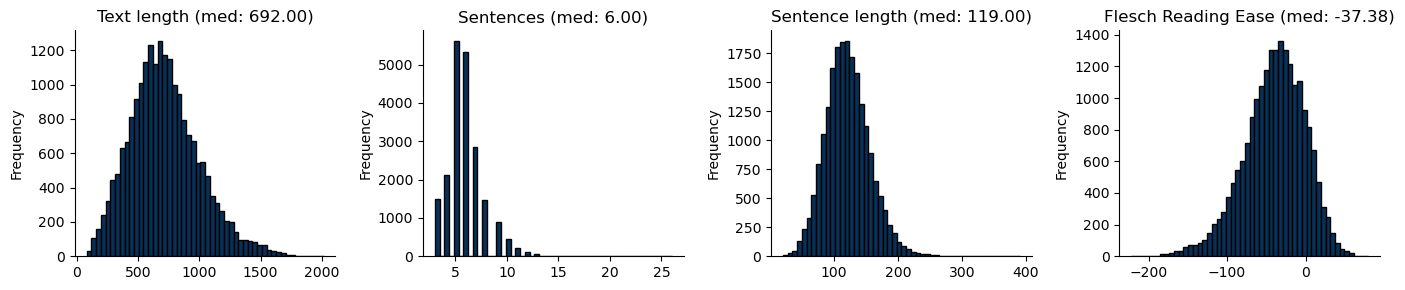


---------------------------------------------------------------------------------------------------------------------
Code duration: 4.576 seconds


In [40]:
dur = time.time()      
file_url  = file_path + '23_data_unstructured_processed.csv' 
data = pd.read_csv(file_url)  
# -------------------------------------------------------------------------------------~----------------------------------------
 

# text statistics
# -------------------------------------------------------------------------------------~----------------------------------------
print("\n text statistics")
print("-----------------------------------------------------------------------")
data['text_l'] = data['text'].apply(len)
data['text_s'] = data['text'].apply(lambda Text: len(re.split(r'[.!?;]', Text)))
data['text_sl'] = data.apply(lambda row: row['text_l'] / row['text_s'] if row['text_s'] > 0 else 0, axis=1)
data['text_fre'] = data['text'].apply(textstat.flesch_reading_ease)


# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
print("\n\n\n~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
print(f"unique: {(not data['document_id'].duplicated().any())}")                       # print duplicates
print(f"length: {len(data)}")                                                          # print length
display(data.head(1))                                                                  # display row
display((data.isna().sum()).to_frame().T)                                              # display nulls
print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


# plot statistics
# -------------------------------------------------------------------------------------~----------------------------------------
fig, ax = plt.subplots(figsize=(14, 3), ncols=4) 
data["text_l"].plot(kind="hist", bins=50, edgecolor="k", color="#093158", ax=ax[0], title=f"Text length (med: {data.text_l.median():.2f})")
data["text_s"].plot(kind="hist", bins=50, edgecolor="k", color="#093158", ax=ax[1], title=f"Sentences (med: {data.text_s.median():.2f})")
data["text_sl"].plot(kind="hist", bins=50, edgecolor="k", color="#093158", ax=ax[2], title=f"Sentence length (med: {data.text_sl.median():.2f})")
data["text_fre"].plot(kind="hist", bins=50, edgecolor="k", color="#093158", ax=ax[3], title=f"Flesch Reading Ease (med: {data.text_fre.median():.2f})")
fig.tight_layout()
sns.despine()
plt.show()

# -------------------------------------------------------------------------------------~----------------------------------------
file_url  = file_path + '24_data_unstructured_statistics.csv'  
data.to_csv(file_url, index=False)
print('\n---------------------------------------------------------------------------------------------------------------------')
print(f"Code duration: {round((time.time()  - dur),3)} seconds")       

------------------------------------------------
<br>
<br>
<br>


## Text sentiment


 text sentiment
-----------------------------------------------------------------------



~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
unique: True
length: 20666


,document_id,text,source,text_l,text_s,text_sl,text_fre,text_pol,text_sub
0,08f70318-bcee-4284-95d8-25539822718c,nota over de toestand van s rijks financiën; b...,Nota over de toestand van ’s Rijks Financiën M...,594,5,118.8,-23.17,-0.15,0.5125


,document_id,text,source,text_l,text_s,text_sl,text_fre,text_pol,text_sub
0,0,0,0,0,0,0,0,0,0


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


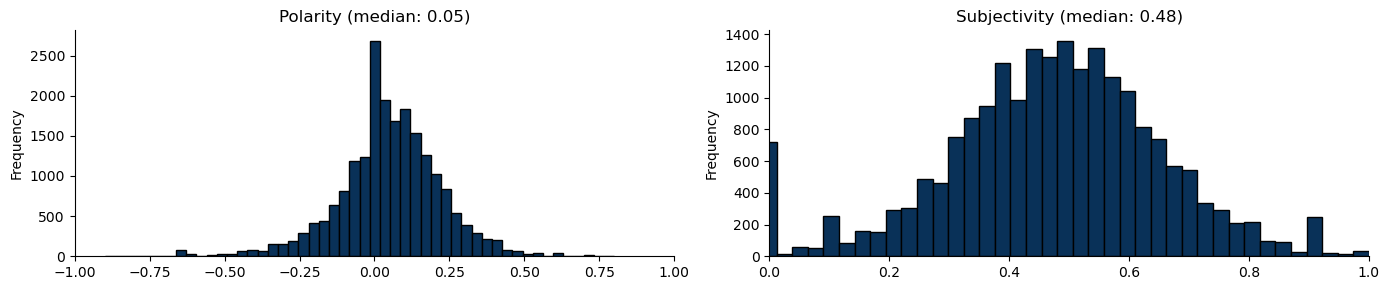


---------------------------------------------------------------------------------------------------------------------
Code duration: 9.002 seconds


In [41]:
dur = time.time()
file_url  = file_path + '24_data_unstructured_statistics.csv' 
data = pd.read_csv(file_url)   
# -------------------------------------------------------------------------------------~----------------------------------------


# text sentimnent
# -------------------------------------------------------------------------------------~----------------------------------------
print("\n text sentiment")
print("-----------------------------------------------------------------------")
data["text_sent"] = data['text'].apply(lambda x: tuple(TextBlob(text=x, analyzer=PatternAnalyzer()).sentiment))
data["text_pol"] = data["text_sent"].str.get(0)
data["text_sub"] = data["text_sent"].str.get(1)
data = data.drop(columns=['text_sent'])                                                      # Drop sentiment column


# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
print("\n\n\n~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
print(f"unique: {(not data['document_id'].duplicated().any())}")                       # print duplicates
print(f"length: {len(data)}")                                                          # print length
display(data.head(1))                                                                  # display row
display((data.isna().sum()).to_frame().T)                                              # display nulls
print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


# plot statistics
# -------------------------------------------------------------------------------------~----------------------------------------
fig, ax = plt.subplots(figsize=(14, 3), ncols=2)
data["text_pol"].plot(kind="hist", bins=50, edgecolor="k", color="#093158", ax=ax[0], title=f"Polarity (median: {data.text_pol.median():.2f})")
data["text_sub"].plot(kind="hist", bins=50, edgecolor="k", color="#093158", ax=ax[1], title=f"Subjectivity (median: {data.text_sub.median():.2f})")
ax[0].set_xlim(-1, 1)
ax[1].set_xlim(0, 1)
fig.tight_layout()
sns.despine()
plt.show()

columns = [col for col in data.columns if col not in ["document_id", "text",'source']]
scaler = StandardScaler()
data[columns] = scaler.fit_transform(data[columns])


# -------------------------------------------------------------------------------------~----------------------------------------
file_url  = file_path + '25_data_unstructured_sentiment.csv' 
data.to_csv(file_url, index=False)
print('\n---------------------------------------------------------------------------------------------------------------------')
print(f"Code duration: {round((time.time()  - dur),3)} seconds")       

------------------------------------------------
<br>
<br>
<br>


## Text lemmanization

In [29]:
dur = time.time()
file_url  = file_path + '25_data_unstructured_sentiment.csv' 
data = pd.read_csv(file_url)   
row = 15293
#data = data.sample(n=100) 
# -------------------------------------------------------------------------------------~----------------------------------------


# step 1: source
# -------------------------------------------------------------------------------------~----------------------------------------
print("\nstep 1: source") 
print("-----------------------------------------------------------------------")
print(data.iloc[row]['text'])                                                          # print row
print(len(data.iloc[row]['text']))                                                     # print length


# step 2: remove punctuation
# -------------------------------------------------------------------------------------~----------------------------------------
print("\n\n\n step 2: remove punctuation") 
print("-----------------------------------------------------------------------")
data['text'] = data['text'].str.replace('[.!?;]', ' ', regex=True)                     # redefine text without punctuation
data['text'] = data['text'].str.replace(r'\s+', ' ', regex=True)                       # redefine text without white space
print(data.iloc[row]['text'])                                                          # print row
print(len(data.iloc[row]['text']))                                                     # print length


# step 3: NLTK tokenize (less intensive)
# -------------------------------------------------------------------------------------~----------------------------------------
print("\n\n\n step 3: NLTK tokenize") 
print("-----------------------------------------------------------------------")
data['text'] = data['text'].apply(word_tokenize)                                       # redfine text into gensim tokens
data['text'] = data['text'].apply(lambda tokens: [t for t in tokens if len(t) > 1])    # redefine text removing 1 character tokens
print(data.iloc[row]['text'])                                                          # print row
print(len(data.iloc[row]['text']))                                                     # print length


# step 4: NLTK processing
# -------------------------------------------------------------------------------------~----------------------------------------
print("\n\n\n step 4: NLTK processing") 
print("-----------------------------------------------------------------------")
stop_words_1 = list(stopwords.words('dutch'))
stop_words_2 = list(pd.read_csv("https://raw.githubusercontent.com/stopwords-iso/stopwords-nl/master/stopwords-nl.txt", header=None).values.flatten())
stop_words_3 = ['allemaal','andere','anderszins','beneden','beide','ben','binnenin','nooit','derde','dikwijls','doe','doen','doet','door','eveneens','gauw','ieder', 'hebbende','hierbeneden','hierboven','hierin','huidig','hunner','tegenover','immer','jijzelf','meestal','meteen','middels','moge','nochtans','whatever','onze','onzer','opzij','overeind','redelijk','steeds','tamelijk','thans','tiende','waarom','waarschijnlijk','zijne','co','én','daarbij','tevens','ervoor','zowel']
stop_words = stop_words_1 + stop_words_2 + stop_words_3

data['text'] = data['text'].apply(
    lambda tokens: [word for word in tokens if word not in stop_words])                # redfine text without stopwords
print(data.iloc[row]['text'])                                                          # print row
print(len(data.iloc[row]['text']))                                                     # print length


# step 5: SpaCy tokenize (more intensive)
# -------------------------------------------------------------------------------------~----------------------------------------
print("\n\n\n step 5: SpaCy tokenize")
print("-----------------------------------------------------------------------")
data['text'] = data['text'].apply(lambda tokens: ' '.join(tokens))                     # redefine text into string
data['text'] = data['text'].apply(nlp)                                                 # redefine text into SpaCy tokens
print(data.iloc[row]['text'])                                                          # print row
print(len(data.iloc[row]['text']))                                                     # print length                                          
for token in (data.iloc[row]['text']): print(f"- word: {token.text}, Lemma: {token.lemma_.lower()}, POS: {token.pos_}")
       
        
# step 6: SpaCy processing
# -------------------------------------------------------------------------------------~----------------------------------------
print("\n\n\n step 6: SpaCy processing")
print("-----------------------------------------------------------------------")
def SpaCy_process(doc):
    types = ('SYM','NUM','PUNCT','VERB','ADP','DET','ADV','PRON','CONJ','INTJ') 
    processed_tokens = [token.lemma_.lower() for token in doc if token.pos_ not in types and not token.is_stop]    
    return processed_tokens
data['text'] = data['text'].apply(SpaCy_process)                                       # redfine text without specific word types
print(data.iloc[row]['text'])                                                          # print row
print(len(data.iloc[row]['text']))                                                     # print length

# step 7: SpaCy detokenize
# -------------------------------------------------------------------------------------~----------------------------------------
print("\n\n\n step 7: SpaCy detokenize")
print("-----------------------------------------------------------------------")
data['text'] = data['text'].apply(lambda tokens: ' '.join(tokens))                     # redfine text into string
print(data.iloc[row]['text'])                                                          # print row
print(len(data.iloc[row]['text']))                                                     # print length

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
print("\n\n\n~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
print(f"unique: {(not data['document_id'].duplicated().any())}")                       # print duplicates
print(f"length: {len(data)}")                                                          # print length
display(data.head(1))                                                                  # display row
display((data.isna().sum()).to_frame().T)                                              # display nulls
print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


# -------------------------------------------------------------------------------------~----------------------------------------
file_url  = file_path + '26_data_unstructured_lemmanized.csv' 
data.to_csv(file_url, index=False)
print('\n---------------------------------------------------------------------------------------------------------------------')
print(f"Code duration: {round((time.time()  - dur),3)} seconds")       


step 1: source
-----------------------------------------------------------------------
situatie in de oekraïne; plannen voorbereiden voor een bijdrage aan de wederopbouw van een oekraïense stad na de oorlog; constaterende dat de oekraïense president zelensky heeft opgeroepen om na de oorlog een oekraïense stad weder op te bouwen; verzoekt de regering dit voorstel van president zelensky te omarmen en plannen voor te bereiden om een bijdrage te leveren aan het wederopbouwen van een oekraïense stad na de oorlog
426



 step 2: remove punctuation
-----------------------------------------------------------------------
situatie in de oekraïne plannen voorbereiden voor een bijdrage aan de wederopbouw van een oekraïense stad na de oorlog constaterende dat de oekraïense president zelensky heeft opgeroepen om na de oorlog een oekraïense stad weder op te bouwen verzoekt de regering dit voorstel van president zelensky te omarmen en plannen voor te bereiden om een bijdrage te leveren aan het weder

,document_id,text,source,text_l,text_s,text_sl,text_fre,text_pol,text_sub
0,08f70318-bcee-4284-95d8-25539822718c,toestand rijks financiën europees regeldruk kl...,Nota over de toestand van ’s Rijks Financiën M...,-0.433714,-0.511112,-0.063503,0.437354,-1.154401,0.23354


,document_id,text,source,text_l,text_s,text_sl,text_fre,text_pol,text_sub
0,0,0,0,0,0,0,0,0,0


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

---------------------------------------------------------------------------------------------------------------------
Code duration: 225.368 seconds


------------------------------------------------
<br>
<br>
<br>


## Text refinement


step 1: source
-----------------------------------------------------------------------
landbouw visserijraad afbouwstrategie gunst groen gewasbeschermingsmiddeal nieuw kabinet belofte groen akkoord recent studie universiteit wageningen universiteit californië ernstig twijfel oproep aanzien schadelijk gevolg gebruik glyfosaat mens gezondheid biodiversiteit bodem water bestrijdingsmiddel glyfosaat europees landbouwgronden europees parlement meerderheid verlenging glyfosaat jaar regering groen woord groen daad ver onderhandeling europees verband aanzien glyfosaat afbouwstrategie gunst groen gewasbeschermingsmiddel
531



 step 2: remove certain words
-----------------------------------------------------------------------
['landbouw', 'visserijraad', 'afbouwstrategie', 'gunst', 'groen', 'gewasbeschermingsmiddeal', 'kabinet', 'belofte', 'groen', 'akkoord', 'recent', 'studie', 'universiteit', 'wageningen', 'universiteit', 'californië', 'ernstig', 'twijfel', 'oproep', 'aanzien', 'schadelijk'

,document_id,text,source,text_l,text_s,text_sl,text_fre,text_pol,text_sub
0,08f70318-bcee-4284-95d8-25539822718c,toestand rijks financiën europees regeldruk kl...,Nota over de toestand van ’s Rijks Financiën M...,-0.433714,-0.511112,-0.063503,0.437354,-1.154401,0.23354


,document_id,text,source,text_l,text_s,text_sl,text_fre,text_pol,text_sub
0,0,0,0,0,0,0,0,0,0


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~



 step 3: inspect word frequency
-----------------------------------------------------------------------


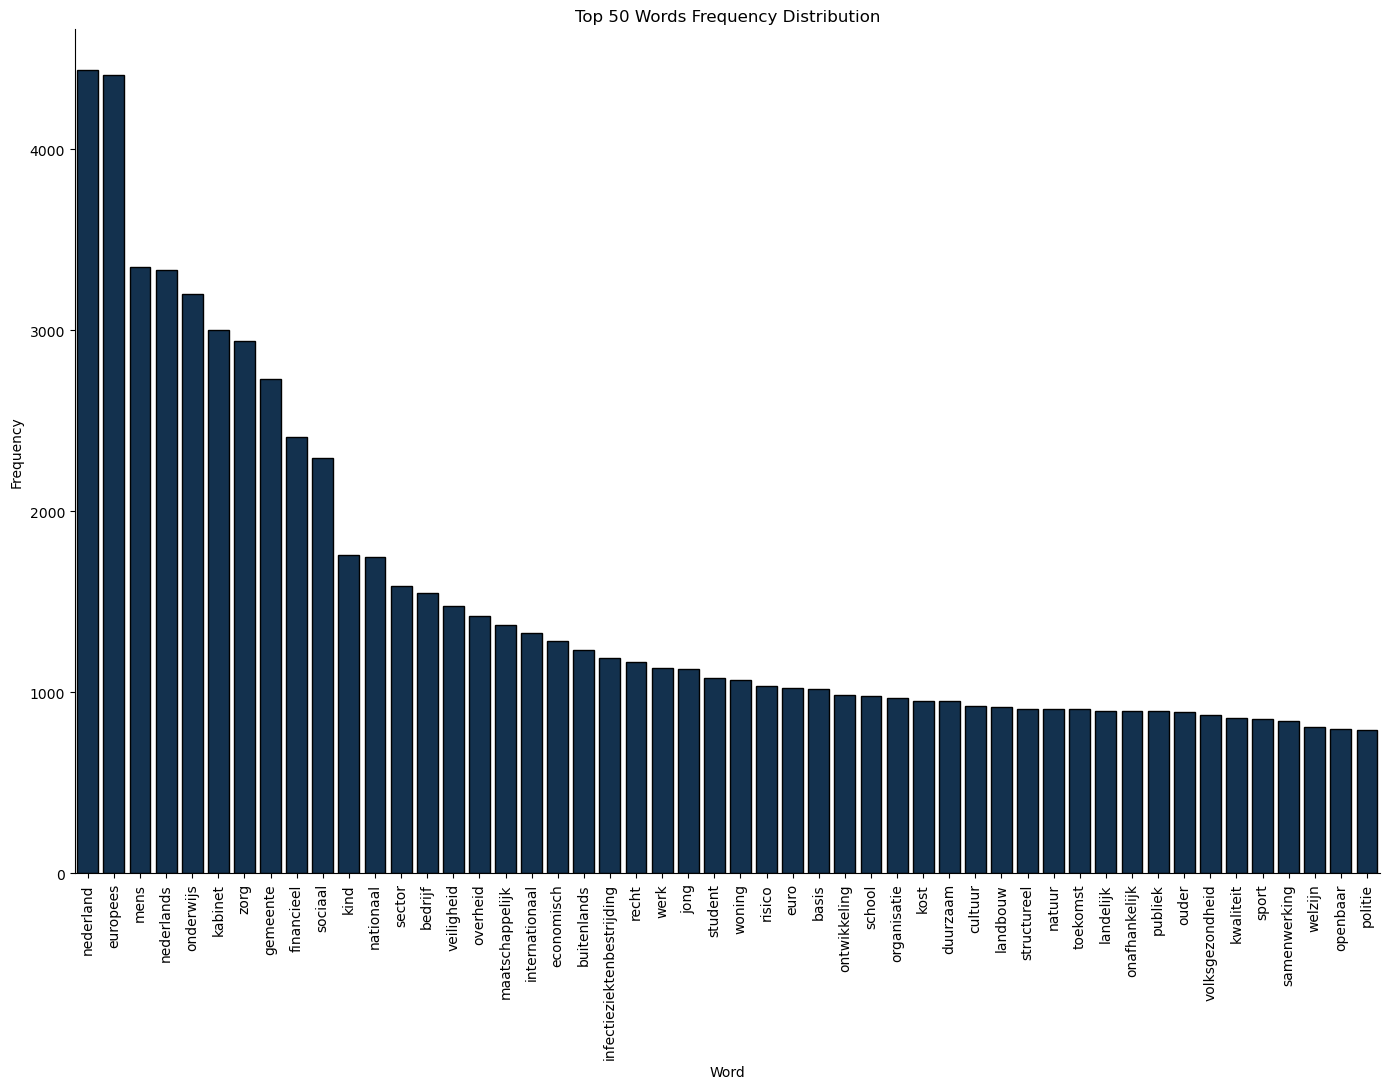




 step 4: inspect word length
-----------------------------------------------------------------------


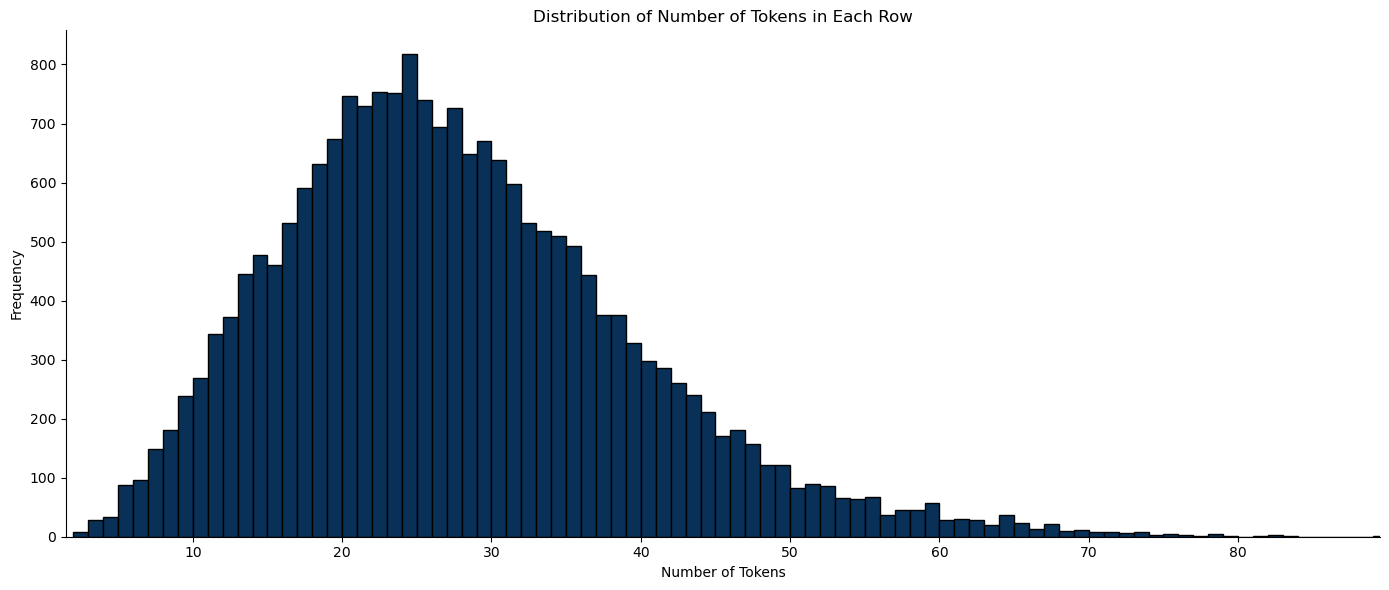




 step 5: inspect short length
-----------------------------------------------------------------------


,source,text
620,Vaststelling van de begrotingsstaten van het M...,sociaal werkgelegenheid
638,Vaststelling van de begrotingsstaten van het M...,sociaal werkgelegenheid
664,Vaststelling van de begrotingsstaten van het M...,sociaal werkgelegenheid
1267,Toekomst pensioenstelsel Motie van de leden Va...,toekomst pensioenstelsel
3718,Gehandicaptenbeleid Motie van het lid Agema ov...,gehandicaptenbeleid ouderinitiatief
11558,Kabinetsformatie 2021 Motie van het lid Wilder...,kabinetsformatie verkiezing
15284,NAVO Motie van het lid Van Haga over vasthoude...,navo noflyzone
18123,Vaststelling van de begrotingsstaten van het M...,economisch klimaat



---------------------------------------------------------------------------------------------------------------------
Code duration: 6.372 seconds


In [42]:
dur = time.time()
file_url  = file_path + '26_data_unstructured_lemmanized.csv' 
data = pd.read_csv(file_url)  
#data = data.sample(n=100) 
row = 5
# -------------------------------------------------------------------------------------~----------------------------------------


# step 1: source
# -------------------------------------------------------------------------------------~----------------------------------------
print("\nstep 1: source")                                                              # print step
print("-----------------------------------------------------------------------")
print(data.iloc[row]['text'])                                                          # print row
print(len(data.iloc[row]['text']))                                                     # print length

# ----------------------------------------------------------------------------
# Visualize frequency distribution
#all_tokens = ' '.join(data['Text']).split()
#freq_dist = FreqDist(all_tokens)
#plt.figure(figsize=(10, 5))
#freq_dist.plot(30, cumulative=False)


# step 2: remove certain words
# -------------------------------------------------------------------------------------~----------------------------------------
print("\n\n\n step 2: remove certain words")                                           # print step
print("-----------------------------------------------------------------------")
data['text'] = data['text'].apply(word_tokenize)                                       # redfine text into tokens
typical_words = ['regering','wet','visie','kamer','commissie','ministerie','vaststelling','advies','partij','begrotingsstat','mening','onderzoek','zaak','maatregel','wijziging','raad','land','mogelijkheid','gevolg','aantal','minister','belang','aanpak','belang','aanpak','plan','middel','gebruik','gebied','voorstel','bijdrage','verband','termijn','overleg','regeling','beleid','doel','begrotingsstaat','groep','effect','miljoen','probleem','gesprek','kaart','geval','afspraak','rol','uitvoering','inzet','deel','wijze','tijd','kader','aandacht','moment','situatie','lid','regel','onderdeel','spraak','vorm']
adjectives = ['groot','lang','laag','hoog','nodig','nieuw','goed','snel','extra','huidig','kort','direct','algemeen','vast','belangrijk','beschikbaar','wettelijk','tijdelijk','voldoende','advies','mogelijk','integraal','breed','concreet','duidelijk',''] 
roman_numerals = ['i', 'ii', 'iii', 'iv', 'v', 'vi', 'vii', 'viii', 'ix', 'x','xi', 'xii', 'xiii', 'xiv', 'xv', 'xvi', 'xvii', 'xviii', 'xix', 'xx','xxi', 'xxii', 'xxiii', 'xxiv', 'xxv', 'xxvi', 'xxvii', 'xxviii', 'xxix', 'xxx','xxxi', 'xxxii', 'xxxiii', 'xxxiv', 'xxxv', 'xxxvi', 'xxxvii', 'xxxviii', 'xxxix', 'xl','xli', 'xlii', 'xliii', 'xliv', 'xlv', 'xlvi', 'xlvii', 'xlviii', 'xlix', 'l','li', 'lii', 'liii', 'liv', 'lv', 'lvi', 'lvii', 'lviii', 'lix', 'lx','lxi', 'lxii', 'lxiii', 'lxiv', 'lxv', 'lxvi', 'lxvii', 'lxviii', 'lxix', 'lxx','lxxi', 'lxxii', 'lxxiii', 'lxxiv', 'lxxv', 'lxxvi', 'lxxvii', 'lxxviii', 'lxxix', 'lxxx','lxxxi', 'lxxxii', 'lxxxiii', 'lxxxiv', 'lxxxv', 'lxxxvi', 'lxxxvii', 'lxxxviii', 'lxxxix', 'xc','xci', 'xcii', 'xciii', 'xciv', 'xcv', 'xcvi', 'xcvii', 'xcviii', 'xcix', 'c']
time_words = ['jaar','dag','week','januari','februari','maart','april','mei','juni','juli','augustus','september','oktober','november','december']
remove_words = typical_words + adjectives+ roman_numerals + time_words\

data['text'] = data['text'].apply(
    lambda tokens: [word for word in tokens if word not in remove_words])              # redfine text without frequent words
print(data.iloc[row]['text'])                                                          # print row
print(len(data.iloc[row]['text']))                                                     # print length
data['text'] = data['text'].apply(lambda tokens: ' '.join(tokens))                     # redefine text into string


# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
print("\n\n\n~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
print(f"unique: {(not data['document_id'].duplicated().any())}")                       # print duplicates
print(f"length: {len(data)}")                                                          # print length
display(data.head(1))                                                                  # display row
display((data.isna().sum()).to_frame().T)                                              # display nulls
print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


# step 3: inspect word frequency
# -------------------------------------------------------------------------------------~----------------------------------------
print("\n\n\n step 3: inspect word frequency")                                         # print step
print("-----------------------------------------------------------------------")
tokens = ' '.join(data['text']).split()                                                # define tokens
freq_dist = FreqDist(tokens)                                                           # define frequency distribution
freq_dist = pd.DataFrame(list(freq_dist.items()), columns=['Word', 'Frequency'])       # redefine frequency distribution
freq_dist = freq_dist.sort_values(by='Frequency', ascending=False)                     # sort frequency distribution
top = 50                                                                               # define top
plt.figure(figsize=(14, 11))                                                           # plot figure
sns.barplot(x='Word', y='Frequency', data=freq_dist.head(top), color='#093158', edgecolor='k')
plt.xticks(rotation='vertical')                                                        # plot label rotation
plt.title(f'Top {top} Words Frequency Distribution')                                   # plot title
plt.xlabel('Word')                                                                     # plot xlabel
plt.ylabel('Frequency')                                                                # plot ylabel
sns.despine()                                                                          # plot despine
plt.tight_layout()                                                                     # plot tightlayout
plt.show()                                                                             # plot show


# step 4: inspect word length
# -------------------------------------------------------------------------------------~----------------------------------------
print("\n\n\n step 4: inspect word length")                                            # print step
print("-----------------------------------------------------------------------")
length = data['text'].apply(lambda x: len(x.split()))                                  # define length, tokens per row
plt.figure(figsize=(14, 6))                                                            # plot figure
plt.hist(length, bins=range(min(length), max(length) + 2), color='#093158', edgecolor='k')
plt.title('Distribution of Number of Tokens in Each Row')                              # plot title
plt.xlabel('Number of Tokens')                                                         # plot xlabel
plt.ylabel('Frequency')                                                                # plot ylabel
plt.xlim(min(length) - 0.5, max(length) + 0.5)                                         # plot xlim
sns.despine()                                                                          # plot despine
plt.tight_layout()                                                                     # plot tightlayout
plt.show()                                                                             # plot show


# step 5: inspect short length
# -------------------------------------------------------------------------------------~----------------------------------------
print("\n\n\n step 5: inspect short length")                                           # print step
print("-----------------------------------------------------------------------")
short = data[length < 3][['source', 'text']]                                           # define short, less than 3 tokens
display(short)                                                                         # display short


# -------------------------------------------------------------------------------------~----------------------------------------
file_url  = file_path + '27_data_unstructured_refined.csv' 
data.to_csv(file_url, index=False)
print('\n---------------------------------------------------------------------------------------------------------------------')
print(f"Code duration: {round((time.time()  - dur),3)} seconds")       